PART 1

In [1]:
pip install matplotlib



SyntaxError: invalid syntax (2185429697.py, line 1)

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

POSE_LABELS = {1: 'wave', 2: 'push', 3: 'crouch', 4: 'sitdown', 5: 'bend'}

# Use your custom skeleton structure (adjusted for 0-based indexing)
SKELETON_EDGES = [
    (0, 1), (1, 2), (1, 8), (8, 9), (1, 5),   
    (2, 3), (3, 4),                             
    (5, 6), (6, 7), (11, 12), (9, 10),          
    (12, 13), (14, 16),                         
    (0, 15), (0, 14), (15, 17), (2, 5), (8, 11), (1, 11)  
]

def plot_skeleton_pose(skeleton_row, label_id):
    """
    Plot skeleton points and connect them to visualize the pose.
    """
    x = skeleton_row[:18]
    y = skeleton_row[18:36]
    confidence = skeleton_row[36:]

    plt.figure(figsize=(5, 5))
    
    # Plot joints
    plt.scatter(x, y, c=confidence, cmap='plasma', s=100, zorder=2)

    # Connect joints based on confidence
    for (i, j) in SKELETON_EDGES:
        if confidence[i] > 0.1 and confidence[j] > 0.1:
            plt.plot([x[i], x[j]], [y[i], y[j]], 'k-', linewidth=2, zorder=1)

    plt.gca().invert_yaxis()
    plt.title(f"Pose: {POSE_LABELS.get(label_id, 'Unknown')}")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.show()




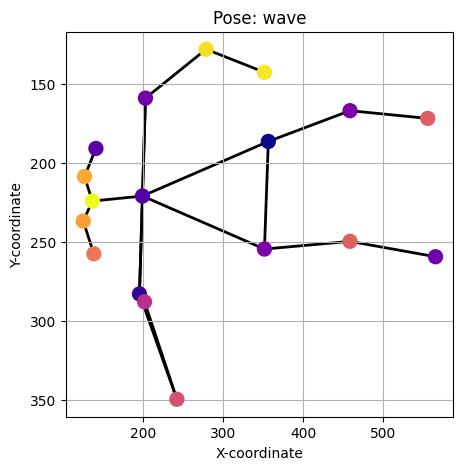

In [78]:
# Load data
skeleton_df = pd.read_csv("Train_skelletonpoints.csv", header=None)
labels_df = pd.read_csv("Train_labels.csv", header=None).T.reset_index(drop=True)

# Plot first sample with connections
plot_skeleton_pose(skeleton_df.iloc[0].values, labels_df.iloc[0, 0])


STEP 2

In [68]:
def plot_avg_csi_amplitude(csi_row):
    """
    Plot average CSI amplitude per subcarrier from one flattened CSI row (length 270).
    """
    csi_matrix = csi_row.reshape((30, 3, 3))
    avg_amplitude = csi_matrix.mean(axis=(1, 2))
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 31), avg_amplitude, marker='o')
    plt.title("Average CSI Amplitude per Subcarrier")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


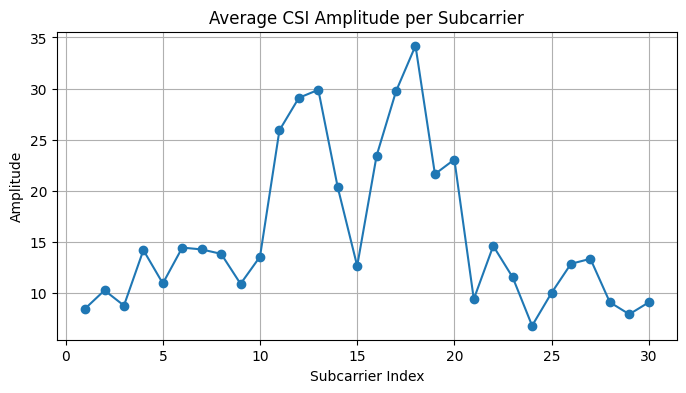

In [69]:
features_df = pd.read_csv("Train_features.csv", header=None).reset_index(drop=True)

plot_avg_csi_amplitude(features_df.iloc[0].values)


STEP 3

In [70]:
def plot_csi_distribution_by_class(features_df, labels_df):
    """
    Plot the distribution of average CSI amplitude per subcarrier for each pose class.
    """
    plt.figure(figsize=(10, 6))

    for label in sorted(POSE_LABELS.keys()):
        class_samples = features_df[labels_df[0] == label]
        avg_amplitude = class_samples.values.reshape(-1, 30, 3, 3).mean(axis=(0, 2, 3))
        plt.plot(range(1, 31), avg_amplitude, label=POSE_LABELS[label])

    plt.title("Average CSI Amplitude per Subcarrier by Pose Class")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


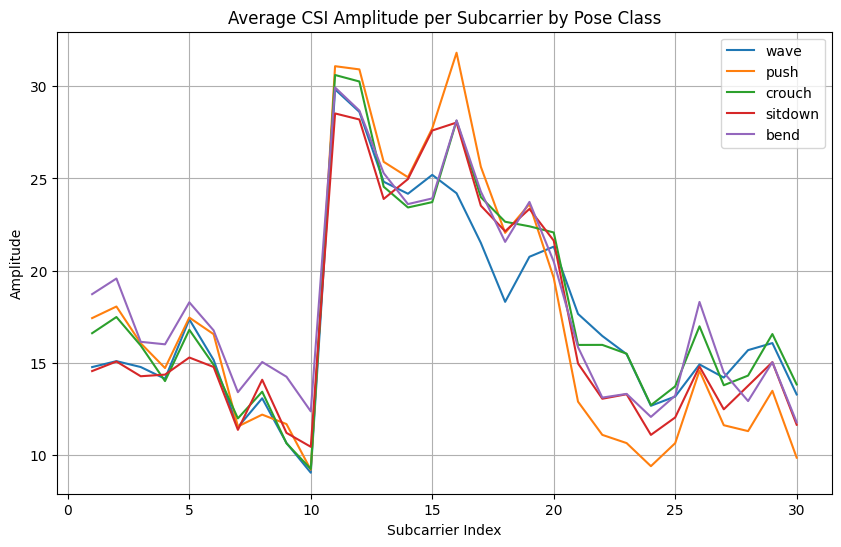

In [71]:
plot_csi_distribution_by_class(features_df, labels_df)


### PART 2

In [72]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


X_train = pd.read_csv("Train_features.csv", header=None)
y_train = pd.read_csv("Train_labels.csv", header=None).T.squeeze() 

# Load test data
X_test = pd.read_csv("Test_features.csv", header=None)
y_test = pd.read_csv("Test_labels.csv", header=None).T.squeeze()


In [73]:
# Create and train the SVM classifier
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # You can tune C and kernel later
svm_model.fit(X_train, y_train)


SVC(C=10)

In [75]:
# Predict
y_pred = svm_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'wave', 'push', 'crouch', 'sitdown', 'bend'
]))


Test Accuracy: 0.8450

Classification Report:
              precision    recall  f1-score   support

        wave       0.85      0.81      0.83        42
        push       0.83      0.90      0.86        39
      crouch       0.84      0.89      0.86        35
     sitdown       0.86      0.84      0.85        38
        bend       0.84      0.80      0.82        46

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.84      0.84       200



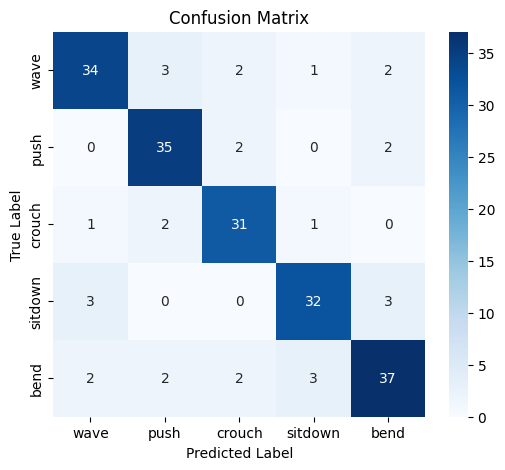

In [76]:
def plot_confusion(conf_matrix, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion(conf_matrix, ['wave', 'push', 'crouch', 'sitdown', 'bend'])
